In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Model'), "..")))

import torch
import timm
from Model.Encoder import Encoder
from Model.TransModule import TransModule, TransModule_Config
from Model.Decoder import Decoder
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from torchvision.utils import save_image
import numpy as np
import cv2

In [2]:
# Load Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    img_size=224,
    patch_size=2,
    in_chans=3,
    embed_dim=192,
    depths=[2, 2, 2],
    nhead=[3, 6, 12],
    strip_width=[2, 4, 7],
    drop_path_rate=0.,
    patch_norm=True
).to(device)
trans_config = TransModule_Config(nlayer=3, d_model=768, nhead=8, norm_first=True)
transfer_module = TransModule(config=trans_config).to(device)
decoder = Decoder(d_model=768, seq_input=True).to(device)

d:\Study\StyleTransfer\style\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
checkpoint = torch.load('../.models/model_complete/checkpoint_40000_epoch.pkl')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4128\3815876412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../.models/model_complete/checkpoint

In [4]:
# Load the state dictionaries
encoder.load_state_dict(checkpoint['encoder'])
transfer_module.load_state_dict(checkpoint['transModule'])
decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

In [5]:
encoder.eval()
transfer_module.eval()
decoder.eval()

Decoder(
  (decoder): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): ReflectionPad2d((1, 1, 1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): ReflectionPad2d((1, 1, 1, 1))
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): Upsample(scale_factor=2.0, mode='nearest')
    (17): ReflectionPad2d((1, 1, 1, 1))
    (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (19): ReLU()
    (20): ReflectionPad2d((1, 1, 1, 1))
    (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (22): ReLU()
    (23): Upsample(scale_factor=2.0, m

In [ ]:
# Paths to images
content_img_path = './image_content.png'
style_img_path = './image_style.png'

# Load images
content_img = Image.open(content_img_path).convert('RGB')
style_img = Image.open(style_img_path).convert('RGB')

content_shape = content_img.size
size = min(content_shape[1], content_shape[0])

# Preprocess the images
only_tensor_transforms = T.Compose([
    T.ToTensor(),
])

shape_transform = T.Compose([
    T.Resize(size),
    T.ToTensor(),
])

content_img = only_tensor_transforms(content_img).unsqueeze(0).to(device)
style_img = shape_transform(style_img).unsqueeze(0).to(device)

# Forward pass through encoders
forward_content = encoder(content_img, arbitrary_input = True)  # [b, h, w, c]
forward_style = encoder(style_img, arbitrary_input = True)      # [b, h, w, c]

content_features, content_res = forward_content[0], forward_content[2]  # [b, c, h, w]
style_features, style_res = forward_style[0], forward_style[2]      # [b, c, h, w]

# Merge the features
merged_features = transfer_module(content_features, style_features)

# Decode the merged features
output = decoder(merged_features, content_res)  # [b, c, h, w]

# Save the generated image
save_image(output, 'generated_image.png')

In [7]:
def tensor_to_opencv_image(tensor: torch.Tensor) -> np.ndarray:
        """Convert a torch tensor to an OpenCV image.

        Args:
            :attr:`tensor` (torch.Tensor): Input tensor. In format (1, C, H, W) or (C, H, W).

        Returns:
            np.ndarray: Output OpenCV image. In format (H, W, C).
        """

        # Check if the tensor is a 4D tensor (batch dimension)
        # If yes, remove the batch dimension
        if tensor.dim() == 4:
            tensor = tensor.squeeze(0)
        elif tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        # Convert the tensor to an OpenCV image
        image = tensor.permute(1, 2, 0).numpy()
        return image

def display_image(image: Image.Image | torch.Tensor | np.ndarray, title: str = "", normalize: bool = True) -> None:
        """Display an image using matplotlib.
        """

        # Check if the input is a tensor
        if isinstance(image, torch.Tensor):
            image = tensor_to_opencv_image(image)
        # Number of channels in the image
        channels = 3
        # Check if the input is numpy array
        if isinstance(image, np.ndarray):
            # Normalize the image
            if normalize:
                image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                image = np.clip(image, 0, 255)
            else:
                # Clip the pixel values to [0, 1]
                image = np.clip(image, 0.0, 1.0)
            try:
                channels = image.shape[2]
            except:
                channels = 1

        # Display the image
        if channels == 1: # If single channel, display in grayscale
            plt.imshow(image, cmap='gray')
        else: # Else display in color
            if channels == 2:
                # Add an extra B channel with zeros
                image = cv2.merge((image, np.zeros_like(image[:,:,0])))
            plt.imshow(image)

        plt.title(title)
        plt.axis('off')
        plt.show()

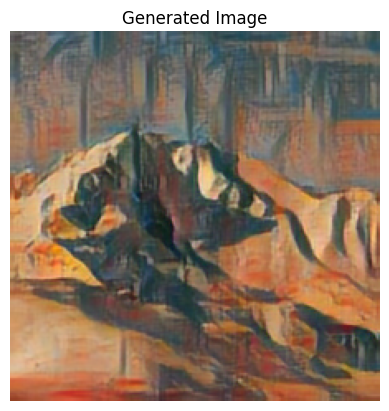

In [8]:
display_image(output.detach().cpu(), title="Generated Image")